# Lipkin Model
#### Kris McBrian
***
Hamiltonian in Quasispin Formalism      
$H = \epsilon J_z - \frac{1}{2} V(J^2_+ + J_-^2) $

In [60]:
import numpy  as np
import matplotlib.pyplot as plt
import qiskit as qk
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram


backend = qk.Aer.get_backend('qasm_simulator')

#### Numerically solve Lipkin model using matrix elements

In [61]:
def diag_lipkin(N,e,V):
    j_max = float(N)/2
    j = np.array([j_max])#np.arange(0.5,j_max+1,1.0) # array of all j values

    for i in range(j.size):
        m = np.arange(-j[i],j[i]+1,1.0)
        H = np.zeros((m.size,m.size))
        for i_m in range(m.size):
            H[i_m][i_m] =  e * m[i_m] 
            if(i_m+2<m.size): # (J_+)**2 term from quasispin H
                H[i_m][i_m+2] = -V/2. * np.sqrt(j[i]*(j[i]+1)-(m[i_m]*(m[i_m]+1)))
                H[i_m][i_m+2] *= np.sqrt(j[i]*(j[i]+1)-((m[i_m]+1)*(m[i_m]+2)))
            if(i_m-2>=0):# (J_-)**2
                H[i_m][i_m-2] = -V/2. * np.sqrt(j[i]*(j[i]+1)-(m[i_m]*(m[i_m]-1)))
                H[i_m][i_m-2] *= np.sqrt(j[i]*(j[i]+1)-((m[i_m]-1)*(m[i_m]-2)))
                    
    return np.linalg.eigvalsh(H)

#### Parity projected mean-field

In [62]:
# Parity Projection
def parity_proj(theta,arg):
    #parity either +1 or -1
    N=arg[0]
    e=arg[1]
    V=arg[2]
    parity=arg[3]
    a = -N*e/2 * (np.cos(2*theta) + (N-1)*V/(2*e) * np.sin(2*theta)**2)
    return a * (1 + parity*np.cos(2*theta)**(N-2))/(1 + parity*np.cos(2*theta)**N)

#### Mean Field Quantum Circuits

In [63]:
# Hamiltonian from Eqn 18 of Lipkin Model notes
def H(N, e, V, Jz, JpJm):
    return -N*e*Jz - 0.5*N*(N-1)*V*JpJm

# evaluate expectation value from results of circuits
def exp_value(eig_val, results, n_shots):
    avg = 0.
    # for every result that was measured
    for a in results.keys():
        # obtain index by converting binary measurement to integer
        b = int(a,2)    # e.g. '10' eigenvalue stored at index 2 of eig
        # weighted sum of eigenvalues and number of measurments
        avg += eig_val[b]*results[a]
    return avg / n_shots

#### $J_z$ Functions

In [64]:
def Jz_circuit(theta, n_shots):
    qc = qk.QuantumCircuit(1,1)
    
    qc.ry(2*theta, 0)
    
    qc.measure(0,0)
    
    exp_values = qk.execute(qc, backend, shots=n_shots)
    results = exp_values.result().get_counts()
    return 0.5*exp_value([1.,-1.], results, n_shots)

def Jz_expvalue(theta):
    return 0.5*np.cos(2*theta)

#### $J_+^2 + J_-^2$ Functions

In [65]:
def JpJm_circuit(theta, n_shots):
    qc = qk.QuantumCircuit(2,2)
    
    qc.ry(2*theta, 0)
    qc.ry(2*theta, 1)

    qc.cx(0,1)
    qc.h(0)    
    
    qc.measure(0,0)
    qc.measure(1,1)
    
    exp_val = qk.execute(qc, backend, shots=n_shots)
    results = exp_val.result().get_counts()
    return exp_value([1.,-1.,0,0], results, n_shots)

def JpJm_expvalue(theta):
    return 0.5*(np.sin(2*theta))**2

#### Solving Generator Coordinate wavefunction

Results start deviating from diagonalization when n_angles < N.

Also for n_angles < N, eigenvalues of H start to be degenerate

In [182]:
def gen_coord(N,e,chi): # can maybe use n + 1 angles for theta, look for minimizing how many angles I need to use
    eps = 0.01
    n_angles = N+1
    theta = np.linspace(0,np.pi,n_angles)
    norm = np.zeros((n_angles,n_angles))
    h = np.zeros((n_angles,n_angles))

    for i in range(n_angles):
        for j in range(n_angles):
            # Fill norm kernel
            norm[i][j] = np.cos(theta[i] - theta[j]) **N
            # Fill H array
            h[i][j] = -N*e/2 * np.cos(theta[i] - theta[j])**(N-2) 
            temp = np.cos(theta[i])**2 * np.sin(theta[j])**2 + np.cos(theta[j])**2 * np.sin(theta[i])**2
            h[i][j] = h[i][j] * (np.cos(theta[i] - theta[j])*np.cos(theta[i] + theta[j]) + chi*(temp))
            
    v,u = np.linalg.eig(norm)
    invroot_norm = np.zeros((n_angles,n_angles))

    for i in range(n_angles):
        for j in range(n_angles):
            for r in range(n_angles):
                if (np.abs(v[r]) > eps):
                    invroot_norm[i][j] += u[i][r] * u[j][r] / np.sqrt(v[r]) 

    H = invroot_norm @ h @ invroot_norm
    return np.linalg.eig(H)[0]

#### Initialize System

In [152]:
n_angles = 30 # resolution for variational method
n_val = 30  # resolution in chi
n_shots = 2**12 # number of measurements of quantum circuit

# system parameters
N = 10
e = 1
chi = np.linspace(0,2,n_val)

theta = np.linspace(0,np.pi,n_angles)
V = chi*e/float(N-1)

In [153]:
diag_result = np.zeros(n_val)
mean_field_result = np.zeros(n_val)
pari_result = np.zeros(n_val)
pari_temp = np.zeros(n_angles)

Jz_results = np.zeros(n_angles)
JpJm_results = np.zeros(n_angles)
circ_result = np.zeros(n_val)

Jz_exact = np.zeros(n_angles)
JpJm_exact = np.zeros(n_angles)
circ_exact = np.zeros(n_val)

generator_coord = np.zeros(n_val)

#### Evaluate Circuits and Exact Expectation Values

In [179]:
for i in range(n_val):
    diag_result[i] = diag_lipkin(N,e,V[i])[0] # Diagonalization
    mean_field_result[i] = -N*e/2. if chi[i]<1 else -N*e/4. * (chi[i] + 1/chi[i]) # mean field: eqn (20)
    for j in range(n_angles):
        # Find minimum of parity projected mean field
        pari_temp[j] = parity_proj(theta[j],[N,e,V[i],+1])
        
        
        Jz_results[j] = Jz_circuit(theta[j],n_shots)
        JpJm_results[j] = JpJm_circuit(theta[j], n_shots)
        #Jz_exact[j] = Jz_expvalue(theta[j])
        #JpJm_exact[j] = JpJm_expvalue(theta[j])
    
    pari_result[i] = np.min(pari_temp)
    circ_result[i] = np.min(H(N,e,V[i],Jz_results,JpJm_results))
    #circ_exact[i] = np.min(H(N,e,V[i],Jz_exact,JpJm_exact)) # yields same line as mean_field_result
    
    a = gen_coord(N,e,chi[i])
    generator_coord[i] = np.amin(a)
    if(i==0):
        gc_array=np.zeros((len(a),n_val))
    gc_array[:,i] = a.copy()

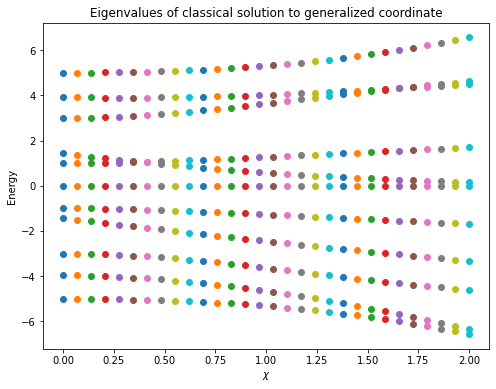

In [180]:
plt.figure(figsize = (8,6))
for i in range(gc_array.shape[0]):
    for j in range(n_val):
        plt.scatter(chi[j],gc_array[i,j])

plt.title("Eigenvalues of classical solution to generalized coordinate")
plt.xlabel(r'$\chi$')
plt.ylabel("Energy")
plt.show()

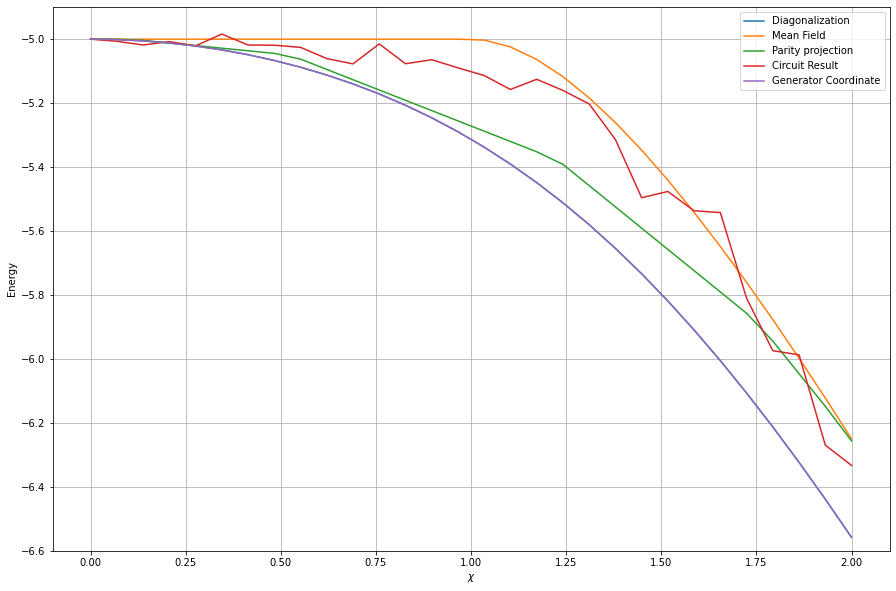

In [181]:
plt.figure(figsize = (15,10))
plt.plot(chi,diag_result,label="Diagonalization")
plt.plot(chi,mean_field_result,label="Mean Field")
plt.plot(chi,pari_result, label="Parity projection")
plt.plot(chi,circ_result,label="Circuit Result")
plt.plot(chi,generator_coord,label="Generator Coordinate")
plt.legend()
plt.xlabel(r'$\chi$')
plt.ylabel("Energy")
plt.ylim([-6.6,-4.9])
plt.grid()
plt.show()

Results from circuit seem to be approaching Mean Field line, with increased n_shots, n_angles